# CA03 – Decision Tree Algorithm

## 1. Data Source and Contents
The dataset is obtained from the Census Bureau and represents salaries of people along
with seven demographic variables. The following is a description of our dataset:
- Number of target classes: 2 ('>50K' and '<=50K') [ Labels: 1, 0 ]
- Number of attributes (Columns): 7, 11*
- Number of instances (Rows): 48,842

In [1]:
# Importing Libraries for EDA/ Data Quality Report
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Loading the Data
df = pd.read_csv("https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true")

### Q.1 Why does it makes sense to discretize columns for this problem?
- Discretizing columns makes sense because the information is technically already "binned", it helps mitigate outliers, and categorical values help produce a more accuarate Decision Tree.
### Q.2 What might be the issues (if any) if we DID NOT discretize the columns
- If we do not clean and discretize our columns, our model will struggle to interpret the data and may create overly complex and inaccurate trees.

## 2. Data Quality Analysis (DQA)

In [3]:
# Printing a few rows
df.head()

hours_per_week_bin occupation_bin  msr_bin capital_gl_bin race_sex_bin  \
0           b. 31-40   b. Mid - Low   b. Mid         c. > 0      c. High   
1            a. 0-30        e. High  c. High         a. = 0      c. High   
2           b. 31-40         a. Low   b. Mid         a. = 0      c. High   
3           b. 31-40         a. Low  c. High         a. = 0       b. Mid   
4           b. 31-40        e. High  c. High         a. = 0       a. Low   

  education_num_bin education_bin workclass_bin            age_bin   flag  y  
0             c. 13  c. Bachelors     b. income   d. 36-40 & 56-60  train  0  
1             c. 13  c. Bachelors     b. income           e. 40-55  train  0  
2           b. 9-12        b. Mid     b. income   d. 36-40 & 56-60  train  0  
3            a. 0-8        a. Low     b. income           e. 40-55  train  0  
4             c. 13  c. Bachelors     b. income  b. 26-30 & 71-100  train  0

In [4]:
# Using info for more detailed info information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   hours_per_week_bin  48842 non-null  object
 1   occupation_bin      48842 non-null  object
 2   msr_bin             48842 non-null  object
 3   capital_gl_bin      48842 non-null  object
 4   race_sex_bin        48842 non-null  object
 5   education_num_bin   48842 non-null  object
 6   education_bin       48842 non-null  object
 7   workclass_bin       48842 non-null  object
 8   age_bin             48842 non-null  object
 9   flag                48842 non-null  object
 10  y                   48842 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 4.1+ MB


In [5]:
#  Checking for missing Values
df.isnull().sum()

hours_per_week_bin    0
occupation_bin        0
msr_bin               0
capital_gl_bin        0
race_sex_bin          0
education_num_bin     0
education_bin         0
workclass_bin         0
age_bin               0
flag                  0
y                     0
dtype: int64

In [6]:
# Looking for Outliers (Using IQR )

def count_outliers(df, column_name):
    # Check if the column contains numeric data
    if pd.api.types.is_numeric_dtype(df[column_name]):
        # Calculate the first and third quartiles
        q1 = df[column_name].quantile(0.25)
        q3 = df[column_name].quantile(0.75)
        
        # Calculate the interquartile range (IQR)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Identify outliers using the bounds and count them
        outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
        return outliers.shape[0]
    else:
        return 0

col_list = ['hours_per_week_bin','occupation_bin','msr_bin','capital_gl_bin',
                             'race_sex_bin','education_num_bin','education_bin','workclass_bin',
                             'age_bin','flag','y']

# Creating a loop to count and indentify where the outliers are
total_outliers = 0

for col_name in col_list:
    num_outliers = count_outliers(df, col_name)
    total_outliers += num_outliers
    print(f"Number of outliers in {col_name}: {num_outliers}")

# Print the total number of outliers
print("Total number of outliers:", total_outliers)

Number of outliers in hours_per_week_bin: 0
Number of outliers in occupation_bin: 0
Number of outliers in msr_bin: 0
Number of outliers in capital_gl_bin: 0
Number of outliers in race_sex_bin: 0
Number of outliers in education_num_bin: 0
Number of outliers in education_bin: 0
Number of outliers in workclass_bin: 0
Number of outliers in age_bin: 0
Number of outliers in flag: 0
Number of outliers in y: 11687
Total number of outliers: 11687


In [7]:
# Summary Statistics for Categorical Variables:
categorical_summary = df.select_dtypes(include='object').describe(include='all')
print(categorical_summary)

       hours_per_week_bin occupation_bin  msr_bin capital_gl_bin race_sex_bin  \
count               48842          48842    48842          48842        48842   
unique                  5              5        3              3            3   
top              b. 31-40   c. Mid - Mid  c. High         a. = 0      c. High   
freq                26639          13971    22047          42525        29737   

       education_num_bin education_bin workclass_bin   age_bin   flag  
count              48842         48842         48842     48842  48842  
unique                 5             5             2         5      2  
top              b. 9-12        b. Mid     b. income  e. 40-55  train  
freq               30324         30324         46012     13963  32561  


In [8]:
# Summary Statistics for Numerical Variables:
numerical_summary = df.describe()
print(numerical_summary)

                  y
count  48842.000000
mean       0.239282
std        0.426649
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


### Data Quality Report
Our dataset primarily consists of categorical variables, with no missing values. Regarding outliers, they were identified due to the nature of the columns, where values are either 0 or 1. Since the majority of values are 0, occurrences of 1 were flagged as outliers. However, this should not pose a problem for our model.
#### Cleaning and Transforming suggestions
 - Get rid of irrelevant characters in the data, like ("a.","b.") as it will affect our next step.
 - Our variables appear to represent intervals already, but they are formatted in a way that won't be compatible with our model. Therefore, we'll need to encode our data.

In [9]:
#Eliminating irrelavant characters in DataFrame ( like b.,c., that appears before the values in most of the columns)
for col in df.drop(columns = ["flag","y"]): # "Flag" and "y" do not need any cleaning on this aspect
    df[col] = df[col].str.split(".", n=1, expand = True)[1]

In [10]:
#Checking if worked
df.head()

hours_per_week_bin occupation_bin msr_bin capital_gl_bin race_sex_bin  \
0              31-40      Mid - Low     Mid            > 0         High   
1               0-30           High    High            = 0         High   
2              31-40            Low     Mid            = 0         High   
3              31-40            Low    High            = 0          Mid   
4              31-40           High    High            = 0          Low   

  education_num_bin education_bin workclass_bin          age_bin   flag  y  
0                13     Bachelors        income    36-40 & 56-60  train  0  
1                13     Bachelors        income            40-55  train  0  
2              9-12           Mid        income    36-40 & 56-60  train  0  
3               0-8           Low        income            40-55  train  0  
4                13     Bachelors        income   26-30 & 71-100  train  0

In [11]:
# Encoding using One-Hot Encoding (From Python Refresher!)
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder object
le = LabelEncoder()

# Iterate over each column in the original DataFrame
for col in df.columns:
    # Fit and transform the encoder on the column values
    encoded_values = le.fit_transform(df[col])
    # Replace the original column with the encoded values
    df[col] = encoded_values

# Checking the new DataFrame
df.head()

hours_per_week_bin  occupation_bin  msr_bin  capital_gl_bin  race_sex_bin  \
0                   1               3        2               2             0   
1                   0               0        0               1             0   
2                   1               1        2               1             0   
3                   1               1        0               1             2   
4                   1               0        0               1             1   

   education_num_bin  education_bin  workclass_bin  age_bin  flag  y  
0                  1              0              0        3     1  0  
1                  1              0              0        4     1  0  
2                  4              4              0        3     1  0  
3                  0              2              0        4     1  0  
4                  1              0              0        1     1  0

## 3. Build Decision Tree Classifier Models

In [12]:
# Before running the model we must split our data into train and test data
# Based on our dataset we will use the variable "flag"
# Where after encoding 1 represents train and 0 represents test

df_train = df[df['flag'] == 1]
df_test = df[df['flag'] == 0]

In [13]:
# The next step is to separate features and labels (target variables)
# To learn the relationship between the input features and the target variable
# We will also drop 'flag' because its purpose was to split the data, from now on it could affect our model if we use it.

# Train Data
x_train = df_train.drop(['y','flag'], axis=1) 
y_train = df_train['y']

# Test data
x_test = df_test.drop(['y','flag'], axis=1)
y_test = df_test['y']

In [14]:
# Importing the library 
from sklearn.tree import DecisionTreeClassifier,plot_tree

In [15]:
# Initiating our model and fiting the Train Dataset
dtree = DecisionTreeClassifier(max_depth=10, random_state=101,
                              max_features = None, min_samples_leaf =15)

dtree.fit(x_train,y_train)
y_pred = dtree.predict(x_test)

## 4. Evaluate Decision Tree Performance
- Confusion Matrix
- Accuracy
- Precsion
- Recall
- F1 Score

In [16]:
# Importing 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [17]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[11592   843]
 [ 1691  2155]]


- True Negatives: 11592
- False Positives: 843
- False Negatives: 1691
- True Positives: 2155

In [18]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8443584546403784


In [19]:
# Precision
precision = precision_score(y_test, y_pred,average=None)
print("Precision:", precision)

Precision: [0.87269442 0.71881254]


In [20]:
# Recall
recall = recall_score(y_test, y_pred,average=None)
print("Recall:", recall)

Recall: [0.93220748 0.56032241]


In [21]:
# F1 score
f1 = f1_score(y_test, y_pred,average=None)
print("F1 Score:", f1)

F1 Score: [0.90146979 0.62974868]


In [22]:
# Using a classification report for better understanding of each class
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     12435
           1       0.72      0.56      0.63      3846

    accuracy                           0.84     16281
   macro avg       0.80      0.75      0.77     16281
weighted avg       0.84      0.84      0.84     16281



## 5. Tune Decision Tree Performance

### Run 1 
##### For Run 1, vary Run 1 columns only and keep other columns to "default".
- Split Criteria – ‘Entropy’ or ‘Gini Impurity'

In [23]:
# Initialize empty lists to store performance metrics
accuracy_list1 = []
recall_list1 = []
precision_list1 = []
f1_score_list1 = []

# Define the splitting criteria
criterion = ['entropy', 'gini']
# Initialize the DecisionTreeClassifier with the specified criterion
for trees in criterion:
    model1 = DecisionTreeClassifier(criterion=trees, random_state=101)
    model1.fit(x_train, y_train)
    y_pred = model1.predict(x_test)
    
    
    accuracy1 = np.mean(y_test == y_pred)
    accuracy_list1.append(accuracy1)
    
    
    precision1 = precision_score(y_test, y_pred)
    precision_list1.append(precision1)
    
    
    recall1 = recall_score(y_test, y_pred)
    recall_list1.append(recall1)
    
    
    f1_value1 = f1_score(y_test, y_pred)
    f1_score_list1.append(f1_value1)

In [24]:
# Storing the results in a Dataframe
df_run1 = pd.DataFrame({'Accuracy':accuracy_list1,
                       'Precision':precision_list1,'Recall':recall_list1,'F1 Score':f1_score_list1},
                      index = criterion)
print("Run 1 Parameters Table")
df_run1

Run 1 Parameters Table


Accuracy  Precision    Recall  F1 Score
entropy  0.835944   0.691555  0.551482  0.613627
gini     0.837172   0.694057  0.555642  0.617184

### Run 2 
##### For Run 2, use the BEST hyper-parameter value of Split Criteria from Run 1
- "Gini"
- Minimum Sample Leaf – Minimum of samples in a leaf node to stop further splitting

In [25]:
accuracy_list2 = []
recall_list2 = []
precision_list2 = []
f1_score_list2 =[]

min_samples_leaf = [5,10,15,20,25,30,35,40]

for trees in min_samples_leaf:
    model2 = DecisionTreeClassifier(criterion='gini', random_state=101,min_samples_leaf=trees)
    model2.fit(x_train, y_train)
    y_pred = model2.predict(x_test)

    accuracy2 = np.mean(y_test == y_pred)
    accuracy_list2.append(accuracy2)
    
    precision2 = precision_score(y_test, y_pred)
    precision_list2.append(precision2)
    
    recall2 = recall_score(y_test, y_pred)
    recall_list2.append(recall2)
    
    f1_value2 = f1_score(y_test, y_pred)
    f1_score_list2.append(f1_value2)

In [26]:
# Storing the results in a Dataframe
df_run2 = pd.DataFrame({'Accuracy':accuracy_list2,
                       'Precision':precision_list2,'Recall':recall_list2,'F1 Score':f1_score_list2},
                      index = min_samples_leaf)
print("Highest Accuracy")
print(df_run2['Accuracy'].max())
print("Run 2 Parameters Table")
df_run2

Highest Accuracy
0.8441127694859039
Run 2 Parameters Table


Accuracy  Precision    Recall  F1 Score
5   0.840550   0.702135  0.564483  0.625829
10  0.840796   0.705036  0.560582  0.624565
15  0.843621   0.708735  0.573843  0.634195
20  0.844113   0.710968  0.573063  0.634610
25  0.843007   0.709416  0.568123  0.630956
30  0.841717   0.703561  0.570203  0.629901
35  0.839936   0.693508  0.577743  0.630355
40  0.840059   0.704680  0.555902  0.621512

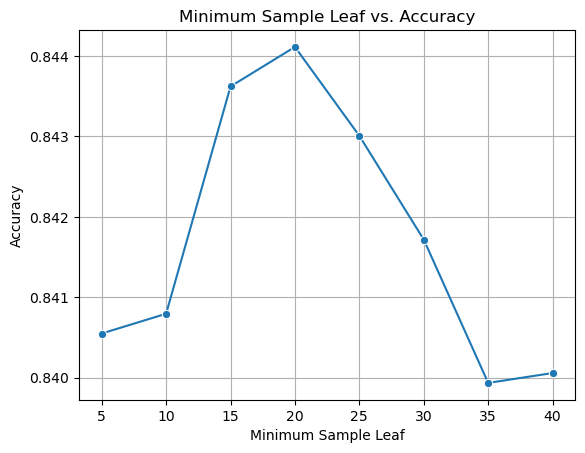

In [27]:
# Graph for comparison
sns.lineplot(x=min_samples_leaf, y=accuracy_list2, marker='o')
plt.title('Minimum Sample Leaf vs. Accuracy')
plt.xlabel('Minimum Sample Leaf')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

### Run 3
#### Maximum Features – The number of features to consider when looking for the best split.
- BEST hyper-parameter values of Split Criteria and Minimum Sample Leaf from Run 1 & 2

In [28]:
accuracy_list3 = []
recall_list3 = []
precision_list3 = []
f1_score_list3 =[]

max_feature = ['sqrt',None,0.3,0.4,0.5,0.6,0.7,0.8]  # Kept getting error with 'auto', so after reseacrh changed to 'sqrt'

for trees in max_feature:
    model3 = DecisionTreeClassifier(criterion='gini', 
                                   random_state=101,min_samples_leaf=20,
                                max_features = trees)
    model3.fit(x_train, y_train)
    y_pred = model3.predict(x_test)
    
    accuracy3 = np.mean(y_test == y_pred)
    accuracy_list3.append(accuracy3)
    
    precision3 = precision_score(y_test, y_pred)
    precision_list3.append(precision3)
    
    recall3 = recall_score(y_test, y_pred)
    recall_list3.append(recall3)
    
    f1_value3 = f1_score(y_test, y_pred)
    f1_score_list3.append(f1_value3)

In [29]:
# Storing the results in a Dataframe
df_run3 = pd.DataFrame({'Accuracy':accuracy_list3,
                       'Precision':precision_list3,'Recall':recall_list3,'F1 Score':f1_score_list3},
                      index = max_feature)
print("Highest Accuracy")
print(df_run3['Accuracy'].max())
print("Run 3 Parameters Table")
df_run3

Highest Accuracy
0.8449726675265647
Run 3 Parameters Table


Accuracy  Precision    Recall  F1 Score
sqrt  0.841472   0.715356  0.546282  0.619490
None  0.844113   0.710968  0.573063  0.634610
0.3   0.839260   0.698290  0.562663  0.623182
0.4   0.841472   0.715356  0.546282  0.619490
0.5   0.842270   0.697344  0.587103  0.637493
0.6   0.842946   0.708509  0.569423  0.631397
0.7   0.844113   0.709213  0.576443  0.635972
0.8   0.844973   0.711452  0.578263  0.637980

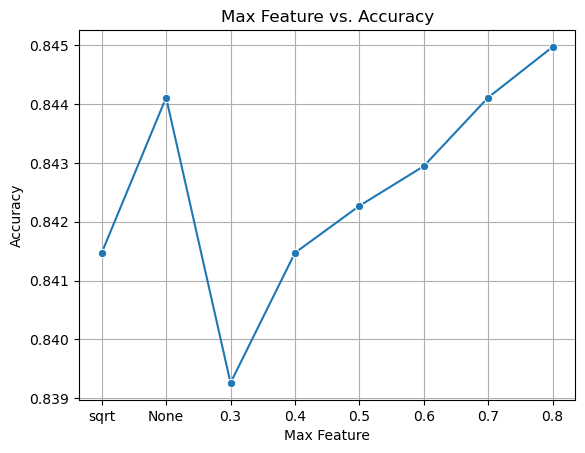

In [30]:
# Convert max_feature values to strings
max_feature_str = [str(feature) for feature in max_feature]

# Graph for comparison
sns.lineplot(x=max_feature_str, y=accuracy_list3, marker='o')
plt.title('Max Feature vs. Accuracy')
plt.xlabel('Max Feature')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

### Run 4
#### For Run 4 use the Best values of Split Crteria, Minimum Sample Leaf, Maximum Feature from previous runs.
- Maximum Depth – Maximum depth of the tree allowed

In [31]:
accuracy_list4 = []
recall_list4 = []
precision_list4 = []
f1_score_list4 =[]

max_depth = [2,4,6,8,10,12,14,16]

for trees in max_depth:
    model4 = DecisionTreeClassifier(criterion='gini', 
                                   random_state=101,min_samples_leaf=20,
                                  max_features = 0.8,max_depth = trees)
    model4.fit(x_train, y_train)
    y_pred = model4.predict(x_test)
    
    accuracy4 = np.mean(y_test == y_pred)
    accuracy_list4.append(accuracy4)
    
    precision4 = precision_score(y_test, y_pred)
    precision_list4.append(precision4)
    
    recall4 = recall_score(y_test, y_pred)
    recall_list4.append(recall4)
    
    f1_value4 = f1_score(y_test, y_pred)
    f1_score_list4.append(f1_value4)

In [32]:
# Storing the results in a Dataframe
df_run4 = pd.DataFrame({'Accuracy':accuracy_list4,
                       'Precision':precision_list4,'Recall':recall_list4,'F1 Score':f1_score_list4},
                      index = max_depth)
print("Highest Accuracy")
print(df_run4['Accuracy'].max())
print("Run 4 Parameters Table")
df_run4

Highest Accuracy
0.8452797739696579
Run 4 Parameters Table


Accuracy  Precision    Recall  F1 Score
2   0.816596   0.695455  0.397816  0.506120
4   0.828020   0.676451  0.521321  0.588840
6   0.837295   0.693501  0.557722  0.618245
8   0.843253   0.714380  0.560582  0.628205
10  0.843929   0.714427  0.565263  0.631151
12  0.845280   0.715212  0.573323  0.636455
14  0.844543   0.714799  0.568903  0.633560
16  0.843990   0.709027  0.575923  0.635581

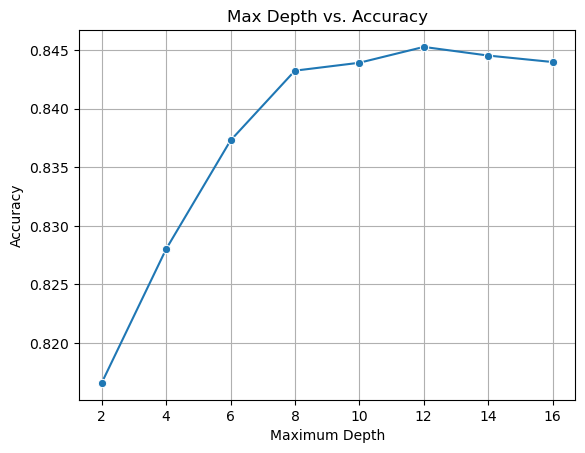

In [33]:
# Graph for comparison
sns.lineplot(x=max_depth, y=accuracy_list4, marker='o')
plt.title('Max Depth vs. Accuracy')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

## 6. Visualize Your Best Decision Tree using GraphViz

-------Best Model Performance Parameters----------
Accuracy: 0.8452797739696579
Precision: 0.7152124554005839
Recall: 0.5733229329173167
F1 Score: 0.6364554769808054
Report : 
               precision    recall  f1-score   support

           0       0.88      0.93      0.90     12435
           1       0.72      0.57      0.64      3846

    accuracy                           0.85     16281
   macro avg       0.80      0.75      0.77     16281
weighted avg       0.84      0.85      0.84     16281



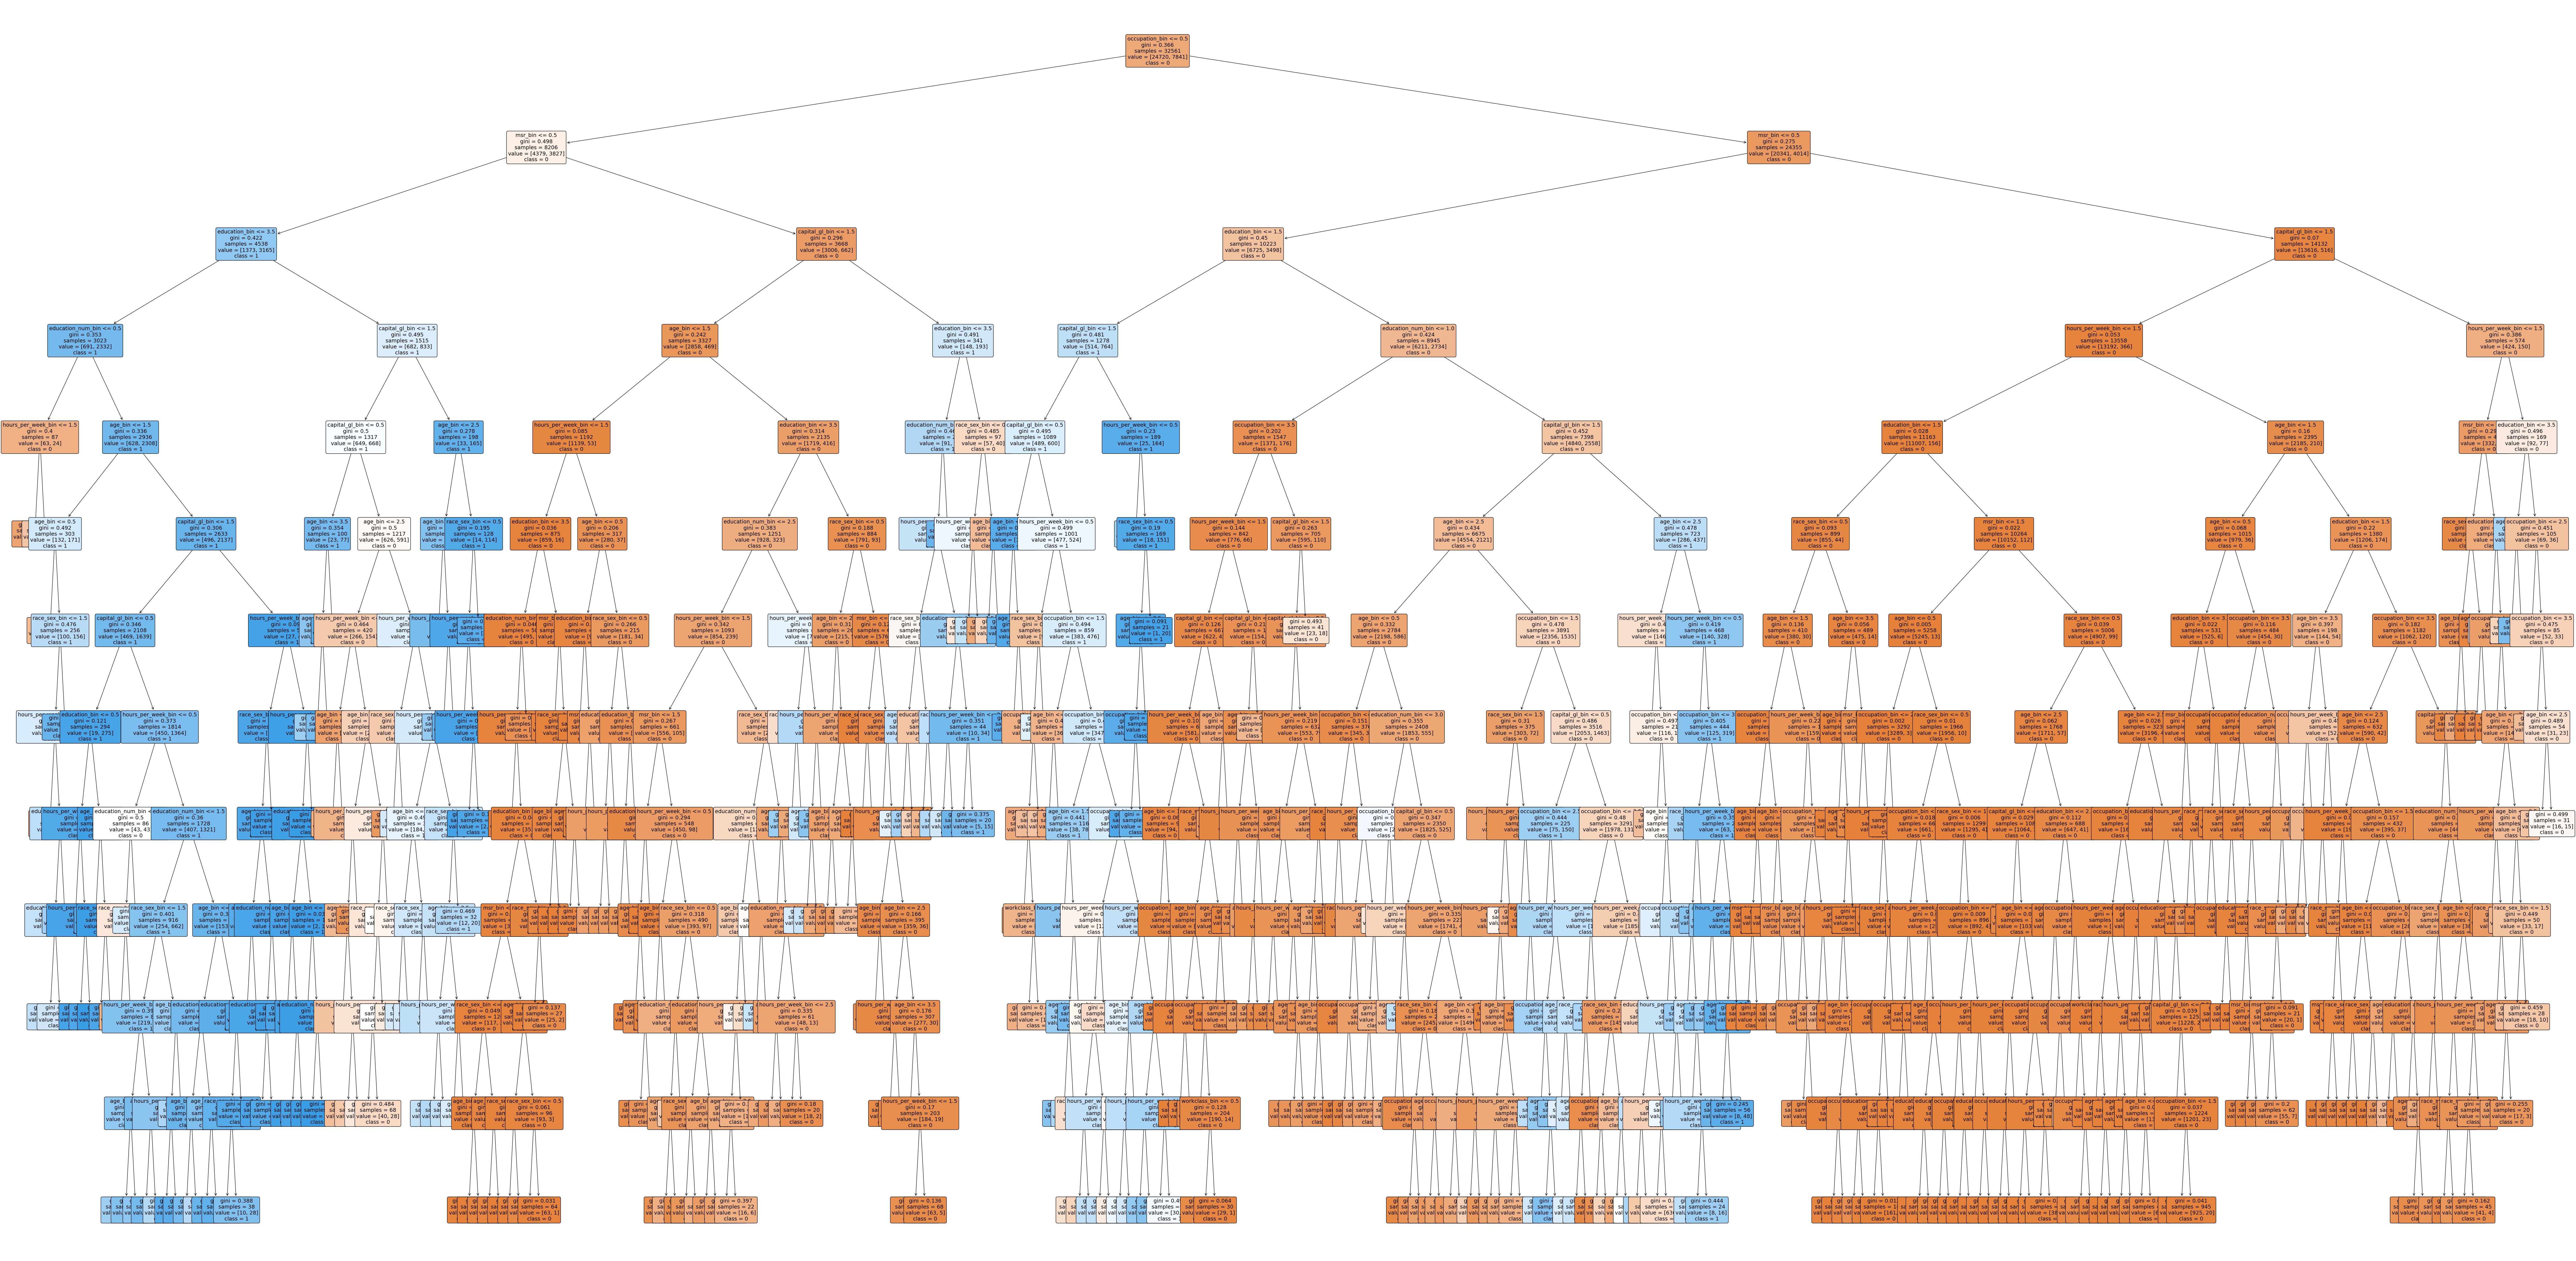

In [34]:
# Instantiate the decision tree classifier with the best hyperparameters
best_dtree = DecisionTreeClassifier(criterion='gini', max_depth=12, random_state=101,
                                    max_features=0.8, min_samples_leaf=20)

# Train the best decision tree model
best_dtree.fit(x_train, y_train)
y_pred = best_dtree.predict(x_test)

# Evaluate performance on the test data
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test,y_pred)

print("-------Best Model Performance Parameters----------")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Report : \n",report)

# Showing the best decision tree
plt.figure(figsize=(120, 60)) # This size takes a while to load, but it shows the whole tree. You can change if you want
plot_tree(best_dtree, feature_names=list(x_train.columns), class_names=['0', '1'],
          filled=True, rounded=True, fontsize=14)
plt.show()


In [35]:
import time 

#check run time while running the best model

# Record the start time
start_time = time.time()

# Code to be timed
best_dtree = DecisionTreeClassifier(criterion='gini', max_depth=12, random_state=101,
                                    max_features=0.8, min_samples_leaf=20)
best_dtree.fit(x_train, y_train)
y_pred = best_dtree.predict(x_test)

# Record the end time
end_time = time.time()

# Compute the elapsed time
elapsed_time = end_time - start_time

## 7. Conclusion
Explain your observations from the above performance tuning effort

### Q.4 How long was your total run time to train the best model?

In [36]:
print('Best Model Run time: {:.2f} seconds'.format(elapsed_time))

Best Model Run time: 0.03 seconds


### Q.5 Did you find the BEST TREE?
- Yes, I did. Following the provided instructions, I tested all hyperparameters and identified the ones with the highest accuracy
### Q.6 Write your observations from the visualization of the best tree
- The tree contains numerous internal nodes, making it challenging to visualize effectively.
### Q.7 Will this Tree “overfit”? (Hint: Is this tree “fully grown”)
- Yes, this tree is fully grown and likely to overfit.

## 8.Prediction using your “trained” Decision Tree Mode

Pick your BEST PERFORMING TREE. Now make prediction of a “new” individual’s Income Category ( <=50K, or >50K )(0 or 1) with the following information.

• Hours Worked per Week = 48

• Occupation Category = Mid - Low

• Marriage Status & Relationships = High

• Capital Gain = Yes

• Race-Sex Group = Mid

• Number of Years of Education = 12

• Education Category = High

• Work Class = Income

• Age = 58

#### Adding the new column and enconding with the same structure as before

In [37]:
# Loading the original data to ensure the encoding will be the same
df_final = pd.read_csv("https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true")

In [38]:
# Define the new row with additional values
new_row = ['b. 41-50', 'c. Mid - Low', 'c. High', 'a. > 0', 'b. Mid', 'b. 9-12', 'c. High', 'b. income', 'e. 55-65','test',1]

# Add the new row to the DataFrame 
df_final.loc[len(df_final)] = new_row

df_final


hours_per_week_bin occupation_bin  msr_bin capital_gl_bin race_sex_bin  \
0               b. 31-40   b. Mid - Low   b. Mid         c. > 0      c. High   
1                a. 0-30        e. High  c. High         a. = 0      c. High   
2               b. 31-40         a. Low   b. Mid         a. = 0      c. High   
3               b. 31-40         a. Low  c. High         a. = 0       b. Mid   
4               b. 31-40        e. High  c. High         a. = 0       a. Low   
...                  ...            ...      ...            ...          ...   
48838           b. 31-40   b. Mid - Low   a. Low         a. = 0       b. Mid   
48839   d. 41-50 & 61-70        e. High  c. High         a. = 0      c. High   
48840           b. 31-40   b. Mid - Low   a. Low         c. > 0      c. High   
48841           e. 51-60        e. High  c. High         a. = 0      c. High   
48842           b. 41-50   c. Mid - Low  c. High         a. > 0       b. Mid   

      education_num_bin education_bin workclass_bin            age_bin   flag  \
0                 c. 13  c. Bachelors     b. income   d. 36-40 & 56-60  train   
1                 c. 13  c. Bachelors     b. income           e. 40-55  train   
2               b. 9-12        b. Mid     b. income   d. 36-40 & 56-60  train   
3                a. 0-8        a. Low     b. income           e. 40-55  train   
4                 c. 13  c. Bachelors     b. income  b. 26-30 & 71-100  train   
...                 ...           ...           ...                ...    ...   
48838           b. 9-12        b. Mid  a. no income   c. 31-35 & 61-70   test   
48839             c. 13  c. Bachelors     b. income   d. 36-40 & 56-60   test   
48840             c. 13  c. Bachelors     b. income           e. 40-55   test   
48841             c. 13  c. Bachelors     b. income   c. 31-35 & 61-70   test   
48842           b. 9-12       c. High     b. income           e. 55-65   test   

       y  
0      0  
1      0  
2      0  
3      0  
4      0  
...   ..  
48838  0  
48839  0  
48840  0  
48841  1  
48842  1  

[48843 rows x 11 columns]

#### Using the same code we used before to clean and encode

In [39]:
#Eliminating irrelavant characters in DataFrame ( like b.,c., that appears before the values in most of the columns)
for col in df_final.drop(columns = ["flag","y"]): # "Flag" and "y" do not need any cleaning on this aspect (target variables)
    df_final[col] = df_final[col].str.split(".", n=1, expand = True)[1]

In [40]:
# Encoding using One-Hot Encoding (From Python Refresher!)
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder object
le = LabelEncoder()

# Iterate over each column in the original DataFrame
for col in df_final.columns:
    # Fit and transform the encoder on the column values
    encoded_values = le.fit_transform(df_final[col])
    # Replace the original column with the encoded values
    df_final[col] = encoded_values

# Checking the new DataFrame
df_final

hours_per_week_bin  occupation_bin  msr_bin  capital_gl_bin  \
0                       1               3        2               2   
1                       0               0        0               1   
2                       1               1        2               1   
3                       1               1        0               1   
4                       1               0        0               1   
...                   ...             ...      ...             ...   
48838                   1               3        1               1   
48839                   3               0        0               1   
48840                   1               3        1               2   
48841                   4               0        0               1   
48842                   2               3        0               2   

       race_sex_bin  education_num_bin  education_bin  workclass_bin  age_bin  \
0                 0                  1              0              0        3   
1                 0                  1              0              0        4   
2                 0                  4              4              0        3   
3                 2                  0              2              0        4   
4                 1                  1              0              0        1   
...             ...                ...            ...            ...      ...   
48838             2                  4              4              1        2   
48839             0                  1              0              0        3   
48840             0                  1              0              0        4   
48841             0                  1              0              0        2   
48842             2                  4              1              0        5   

       flag  y  
0         1  0  
1         1  0  
2         1  0  
3         1  0  
4         1  0  
...     ... ..  
48838     0  0  
48839     0  0  
48840     0  0  
48841     0  1  
48842     0  1  

[48843 rows x 11 columns]

In [41]:
# Extract the values of the last row
last_row_values = df_final.iloc[-1].values

# Create a new DataFrame with the values of the last row
new_df = pd.DataFrame([last_row_values], columns=df_final.columns)

new_df

hours_per_week_bin  occupation_bin  msr_bin  capital_gl_bin  race_sex_bin  \
0                   2               3        0               2             2   

   education_num_bin  education_bin  workclass_bin  age_bin  flag  y  
0                  4              1              0        5     0  1

In [42]:
# Droping the target variable 'y' from new_df
new_df_test = new_df.drop(['y','flag'], axis=1)

# Predicting using the best decision tree model
predictions = best_dtree.predict(new_df_test)
print("Based on the information this new person will be on class",predictions)

Based on the information this new person will be on class [1]


In [43]:
# Probability 
pred_prob = best_dtree.predict_proba(new_df_test)
print(pred_prob)

[[0.04761905 0.95238095]]


- Q.8 What is the probability that your prediction for this person is correct?

In [44]:
positive_class_probability = pred_prob[0][1]
print("Probability of belonging to class 1:", positive_class_probability)

Probability of belonging to class 1: 0.9523809523809523
